# Выбор региона для разработки новых нефтяных месторождений 

**Заказчик** -  добывающая компания «ГлавРосГосНефть».


**Входные данные** - пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 


**Задача** - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 


**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Параметры таблиц:**
- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Создание-модели" data-toc-modified-id="Создание-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Обзор данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import math 
pd.options.mode.chained_assignment = None

from IPython.display import display


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
from scipy import stats as st

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

import time

Сохраним данные в таблицу.

In [2]:
region_1 = pd.read_csv('geo_data_0.csv')
region_2 = pd.read_csv('geo_data_1.csv')
region_3 = pd.read_csv('geo_data_2.csv')


C помощью функции `info()` посмотрим общую информацию об исходных данных.

In [3]:
def get_info(data):
    display(data.head())
    display(data.info(memory_usage='deep'))
    
get_info(region_1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

Таблица **region_1** содержит 5 столбцов и 10000 строк, пропущенные значения отсутствуют. В таблице присутствуют 4 параметра типа `float` и один параметр типа `object`. Всего таблица занимает 9.0 МВ памяти.


In [4]:
get_info(region_2)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

Таблица **region_2** содержит 5 столбцов и 10000 строк, пропущенные значения отсутствуют. В таблице присутствуют 4 параметра типа `float` и один параметр типа `object`. Всего таблица занимает 9.0 МВ памяти.


In [5]:
get_info(region_3)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

Таблица **region_3** содержит 5 столбцов и 10000 строк, пропущенные значения отсутствуют. В таблице присутствуют 4 параметра типа `float` и один параметр типа `object`. Всего таблица занимает 9.0 МВ памяти.

Проверим параметры каждого региона на мультиколлинеарность.

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


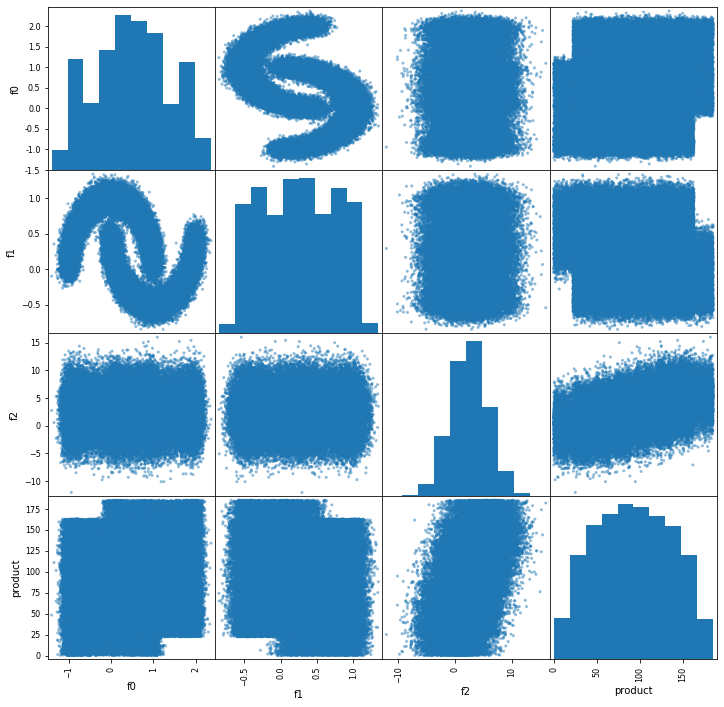

In [6]:
pd.plotting.scatter_matrix(region_1.loc[:,'f0':'product'], figsize=(12,12))
region_1.loc[:,'f0':'product'].corr()

В первом регионе видим умеренную отрицательную взаимосвязь между параметрами **f0 и f1**. Также наблюдается умеренная положительная связь между параметрами **f2 и product**. 

Посмотрим на взаимосвязь параметров во втором регионе.

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


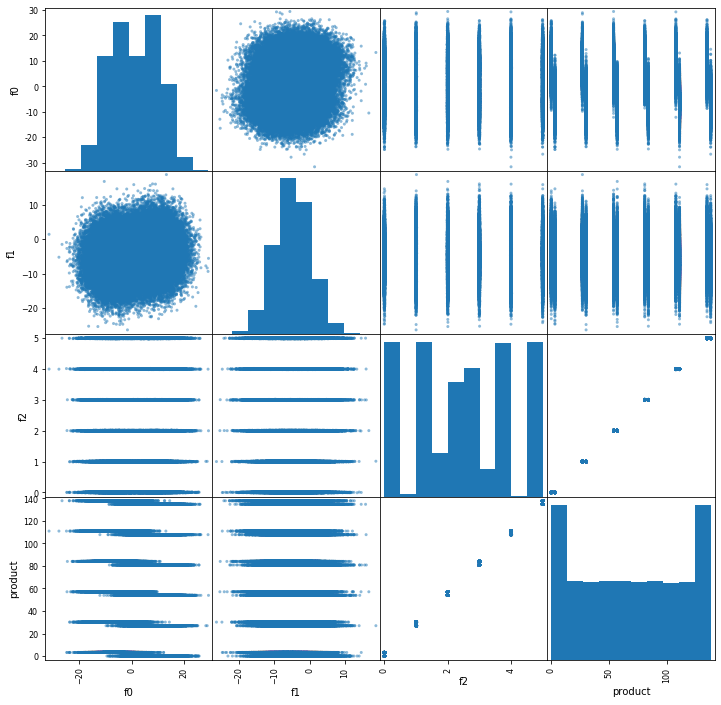

In [7]:
pd.plotting.scatter_matrix(region_2.loc[:,'f0':'product'], figsize=(12,12))
region_2.loc[:,'f0':'product'].corr()

Видим, что между параметрами **f2 и product** (где product является целевым признаком) очень высокая положительная корреляция - 0.999. Между остальными параметрами корреляции не наблюдается.

Посмотрим на взаимосвязь параметров в третьем регионе.

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


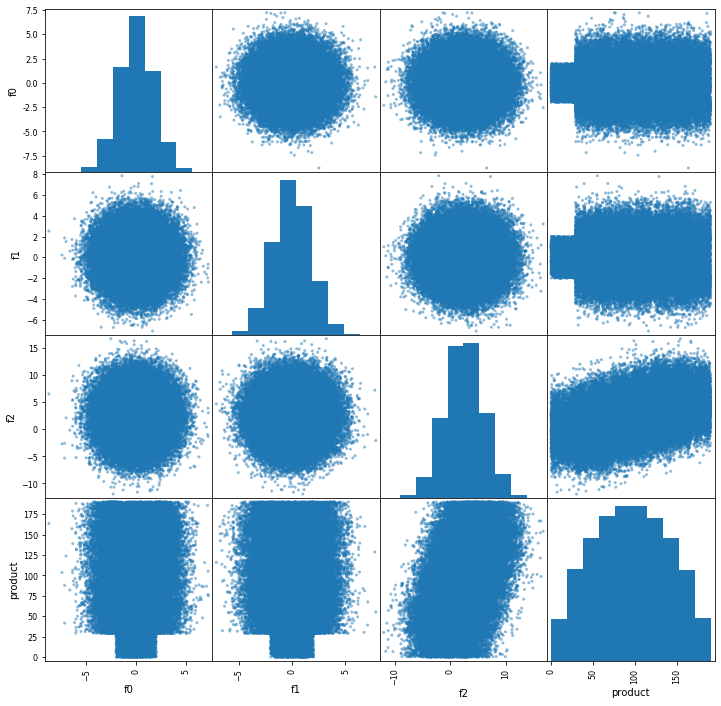

In [8]:
pd.plotting.scatter_matrix(region_3.loc[:,'f0':'product'], figsize=(12,12))
region_3.loc[:,'f0':'product'].corr()

Корреляция между параметрами **f2 и product** умеренная положительная. Между остальными параметрами корреляции не наблюдается. Для построения моделей оставим все параметры, так как сильных взаимосвязей между признаками не выявлено.


С данными ознакомились, подготовим данные для моделирования.

## Подготовка данных 

Для каждого региона разделим данные на две выборки: обучающую и валидационную.

Столбец **Id** (уникальный идентификатор скважины) не будем использовать при моделировании, так как он не является признаком и не влияет на запас сырья.

Напишем функцию, которая разделит исходную таблицу на тестовую и валидлационную, выделит признаки и целевой признак для каждой выборки (параметр **product** - это целевой признак, а все остальные - признаки)
и маштабирует количественные признаки.

In [9]:
def split_train_valid(data):
    '''Возвращает train_features, train_target, valid_features, valid_target. Применяется маштабирование.'''
    #выделение тестовую и валидационную выборки для 1 региона
    train, valid = train_test_split(data.loc[:,'f0':'product'], test_size=0.25, random_state=13)

    print('Размер выборок')
    print('Исходная таблица:',data.loc[:,'f0':'product'].shape)
    print('Обучающая выборка:',train.shape)
    print('Тестовая выборка:',valid.shape)
    print('')
    
    #выделение признаков и целевого признака для обучающей и валидационной выборок
    train_features = train.drop('product', axis=1)
    train_target = train['product']
    
    valid_features = valid.drop('product', axis=1)
    valid_target = valid['product']
    
    print('Размер train_features:',train_features.shape)
    print('Размер train_target:',train_target.shape)
    print('Размер valid_features:',valid_features.shape)
    print('Размер valid_target:',valid_target.shape)
    
    #маштабирование количественных признаков
    numeric = train_features.columns

    scaler = StandardScaler()
    scaler.fit(train_features[numeric]) 

    train_features[numeric] = scaler.transform(train_features[numeric])
    valid_features[numeric] = scaler.transform(valid_features[numeric])
    
    return valid, train_features, train_target, valid_features, valid_target


Получим выборки для первого региона.

In [10]:
valid_reg_1, train_reg_1_features, train_reg_1_target, valid_reg_1_features, valid_reg_1_target = split_train_valid(region_1)


Размер выборок
Исходная таблица: (100000, 4)
Обучающая выборка: (75000, 4)
Тестовая выборка: (25000, 4)

Размер train_features: (75000, 3)
Размер train_target: (75000,)
Размер valid_features: (25000, 3)
Размер valid_target: (25000,)


Получим выборки для второго региона.

In [11]:
valid_reg_2, train_reg_2_features, train_reg_2_target, valid_reg_2_features, valid_reg_2_target = split_train_valid(region_2)


Размер выборок
Исходная таблица: (100000, 4)
Обучающая выборка: (75000, 4)
Тестовая выборка: (25000, 4)

Размер train_features: (75000, 3)
Размер train_target: (75000,)
Размер valid_features: (25000, 3)
Размер valid_target: (25000,)


Получим выборки для третьего региона.

In [12]:
valid_reg_3, train_reg_3_features, train_reg_3_target, valid_reg_3_features, valid_reg_3_target = split_train_valid(region_3)


Размер выборок
Исходная таблица: (100000, 4)
Обучающая выборка: (75000, 4)
Тестовая выборка: (25000, 4)

Размер train_features: (75000, 3)
Размер train_target: (75000,)
Размер valid_features: (25000, 3)
Размер valid_target: (25000,)


Данные подготовили. Перейдем к созданию моделей.

## Создание модели

Создадим и обучим модель линейной регрессии для трех регионов.
Для этого напишем функцию.

In [13]:
def get_predicted(train_features,train_target,valid_features):
    model = LinearRegression()
    model.fit(train_features, train_target)
    return model.predict(valid_features)


Предскажем запас сырья в скважинах 1 региона.

In [14]:
valid_reg_1['predicted'] = get_predicted(train_reg_1_features,train_reg_1_target,valid_reg_1_features)
valid_reg_1.head()

,f0,f1,f2,product,predicted
72031,0.344571,-0.272941,-2.099642,170.053522,68.927415
27978,1.652531,-0.206616,1.868818,61.453092,99.176667
55639,-0.253885,0.993549,1.584251,145.743331,73.078440
51955,1.085273,0.155305,-0.680978,42.100082,75.076824
52145,0.017405,0.081738,-1.458572,99.160596,66.902659


Посмотрим на фактический и предсказанный средний запас сырья, а также на RMSE модели на валидационной выборке первого региона. В качестве среднего значения будем использовать медиану, чтобы нивелировать влияние аномальных значений.

In [15]:
def plot_target_predict(data, target, predict, region):
    '''Выводит гистограмму фактического и предсказанного распределения запаса сырья в скважинах'''
    ax = data.plot(kind='hist',
                   y=target,
                   histtype='step',
                   figsize=(9,6),
                   bins=100,
                   linewidth=5,
                   alpha=0.7,
                   label='Фактический запас сырья',
    )

    data.plot(kind='hist',
              y=predict,
              histtype='step',
              bins=100,
              linewidth=5,
              alpha=0.7,
              label='Предсказанный запас сырья',
              ax=ax,
              grid=True,
              legend=True,
    ) 

    plt.title('Распределение запаса сырья в скважинах для '+region, fontsize=13)
    plt.ylabel('Количество, штук', fontsize=12)
    plt.xlabel('Объем запаса в скважине, тыс. баррелей', fontsize=12)
    plt.show()
    
    
def score(target, predict):
    '''Выводит фактический и предсказанный средний запас сырья в регионе и RMSE'''
    print('Фактический средний запас сырья: {:.3f} тыс. баррелей.'.format(target.median()))
    print('Предсказанный средний запас сырья: {:.3f} тыс. баррелей.'.format(predict.median()))

    rmse = math.sqrt(mean_squared_error(target, predict))
    print('RMSE модели для 1 региона: {:.3f} тыс. баррелей.'.format(rmse))



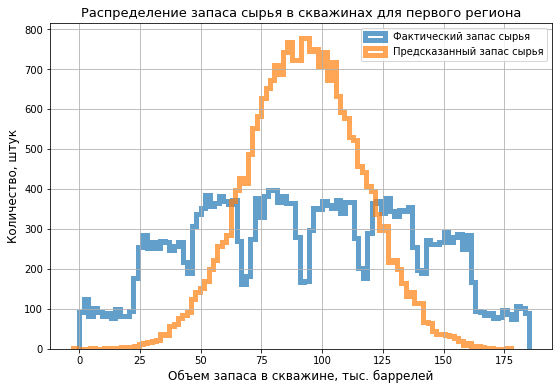

Фактический средний запас сырья: 91.758 тыс. баррелей.
Предсказанный средний запас сырья: 92.518 тыс. баррелей.
RMSE модели для 1 региона: 37.695 тыс. баррелей.


In [16]:
plot_target_predict(valid_reg_1, 'product', 'predicted', 'первого региона')
score(valid_reg_1_target, valid_reg_1['predicted'])

По гистограмме распределения фактического и предсказанного запаса сырья в скважинах видим, что распределения в первом регионе лежат в одном диапазоне данных. В предсказанных данных наблюдаем пик в райное 70-110 тыс. баррелей, когда основные фактические данные лежат в диапазоне 60-130 тыс. баррелей. Видим, что для некоторых скважин модель предсказала отрицательный запас сырья.


Средний фактический запас сырья - 91.758 тыс. баррелей, а предсказанный - 92.518 тыс. баррелей. RMSE для первого региона составило 37.695 тыс. баррелей - это 42% от среднего значения фактического запаса, достаточно большая ошибка.

Добавим полученные значения в сводную таблицу.

In [17]:
result = pd.DataFrame({"Регион": ["Регион №1"], 
                       "Фактический средний запас сырья": [91.758], 
                       "Предсказанный средний запас сырья": [92.518],
                       "RMSE": [37.695],
                      })
result

,Регион,Фактический средний запас сырья,Предсказанный средний запас сырья,RMSE
0,Регион №1,91.758,92.518,37.695


Предскажем запас сырья в скважинах 2 региона.

In [18]:
valid_reg_2['predicted'] = get_predicted(train_reg_2_features,train_reg_2_target,valid_reg_2_features)
valid_reg_2.head()

,f0,f1,f2,product,predicted
72031,2.404544,1.392635,3.003099,80.859783,82.215551
27978,7.863461,-3.074607,4.994210,134.766305,135.186645
55639,-10.829960,-4.771709,3.006065,84.038886,84.348269
51955,10.964350,-3.753278,4.992659,134.766305,134.710099
52145,16.457302,-7.863488,4.000320,107.813044,107.257408


Посмотрим на фактический и предсказанный средний запас сырья, а также на RMSE модели на валидационной выборке второго региона.

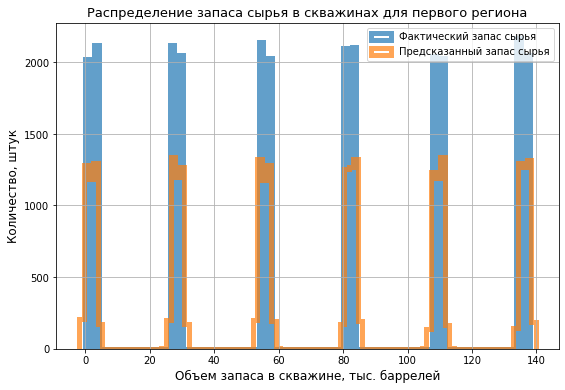

Фактический средний запас сырья: 80.860 тыс. баррелей.
Предсказанный средний запас сырья: 79.351 тыс. баррелей.
RMSE модели для 1 региона: 0.894 тыс. баррелей.


In [19]:
plot_target_predict(valid_reg_2, 'product', 'predicted', 'первого региона')
score(valid_reg_2_target, valid_reg_2['predicted'])

Во втором регионе модель очень точно предсказала запас сырья в скважинах - повторяет фактическое распределение сырья. Мы видим, что скважины второго региона имеют определенный запас сырья: 0-5 тыс. баррелей, 25-30 тыс.баррелей, 55-60 тыс.баррелей и т.д. Можно сказать, что наблюдается равномерное распределение количества скважин по объемам сырья.

Средний фактический запас сырья - 80.860 тыс. баррелей, а предсказанный - 79.351 тыс. баррелей. RMSE для второго региона составило 0.894 тыс. баррелей - очень маленькая ошибка.

Добавим полученные значения в сводную таблицу.

In [20]:
result = result.append({"Регион": "Регион №2", 
                       "Фактический средний запас сырья": 80.860, 
                       "Предсказанный средний запас сырья": 79.351,
                       "RMSE": 0.894},
                       ignore_index=True)
result

,Регион,Фактический средний запас сырья,Предсказанный средний запас сырья,RMSE
0,Регион №1,91.758,92.518,37.695
1,Регион №2,80.860,79.351,0.894


Предскажем запас сырья в скважинах 3 региона.

In [21]:
valid_reg_3['predicted'] = get_predicted(train_reg_3_features,train_reg_3_target,valid_reg_3_features)
valid_reg_3.head()

,f0,f1,f2,product,predicted
72031,-0.370020,0.667530,-4.538057,76.447828,54.556699
27978,1.525227,-4.025469,1.634140,60.054617,90.189453
55639,0.881421,4.007687,10.713461,160.069409,141.822812
51955,2.229994,-1.056556,-0.747277,93.090521,76.183577
52145,2.442010,1.116135,8.983982,133.124375,131.928489


Посмотрим на фактический и предсказанный средний запас сырья, а также на RMSE модели на валидационной выборке третьего региона.

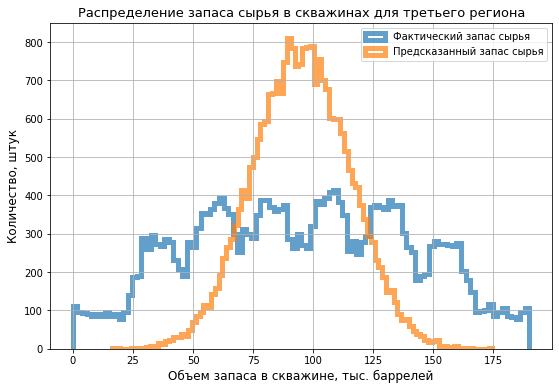

Фактический средний запас сырья: 95.020 тыс. баррелей.
Предсказанный средний запас сырья: 94.913 тыс. баррелей.
RMSE модели для 1 региона: 40.022 тыс. баррелей.


In [22]:
plot_target_predict(valid_reg_3, 'product', 'predicted', 'третьего региона')
score(valid_reg_3_target, valid_reg_3['predicted'])

По гистограмме распределения фактического и предсказанного запаса сырья в скважинах видим, что распределения в третьем регионе лежат в одном диапазоне данных. В предсказанных данных наблюдаем пик в райное 70-110 тыс. баррелей, когда основные фактические данные лежат в диапазоне 60-130 тыс. баррелей. 

Средний фактический запас сырья - 95.020 тыс. баррелей, а предсказанный - 94.913 тыс. баррелей. RMSE для первого региона составило 40.022 тыс. баррелей - это 42% от среднего значения фактического запаса, достаточно большая ошибка.

Добавим полученные значения в сводную таблицу.

In [23]:
result = result.append({"Регион": "Регион №3", 
                       "Фактический средний запас сырья": 95.020, 
                       "Предсказанный средний запас сырья": 94.913,
                       "RMSE": 40.022},
                       ignore_index=True)
result

,Регион,Фактический средний запас сырья,Предсказанный средний запас сырья,RMSE
0,Регион №1,91.758,92.518,37.695
1,Регион №2,80.860,79.351,0.894
2,Регион №3,95.020,94.913,40.022


Для первого и третьего региона предсказания модели лежат в диапазоне фактического запаса сырья, а для второго региона предсказания модели в точности отражают фактическую картину. 

Первый и третий регионы имеют наибольшее среднее значение сырья в скважинах, но при этом им свойственно достаточно высокое значение RMSE. Хотя во втором регионе наблюдается самое низкое значение среднего запаса сырья, при этом у него минимальное значение RMSE.


## Подготовка к расчёту прибыли 

Сохраним ключевые показатели для расчёта прибыли в переменные.

In [2]:
#общий бюджет на разработку скважин в регионе
BUDGET = 10_000_000_000

#бюджет на разработку одной скважины
BUDGET_FROME_ONE_UNIT = BUDGET / 200

#доход с тысячи баррелей
INCOME_FROME_ONE_UNIT = 450000

print('Бюджет на разработку одной сквадины:',BUDGET_FROME_ONE_UNIT)

Бюджет на разработку одной сквадины: 50000000.0


Рассчитаем точку безубыточности для разработки одной скважины.

In [25]:
bep = INCOME_FROME_ONE_UNIT/BUDGET_FROME_ONE_UNIT
print('Точка безубыточности для разработки одной скважины: {:.3f} тыс. баррелей'.format(bep))


Точка безубыточности для разработки одной скважины: 111.111 тыс. баррелей


Чтобы разработка скважины была безубыточной, в ней должно находиться не менее 111.111 тыс. баррелей.
Сравним полученное значение со средним запасом в регионах.

In [26]:
result

,Регион,Фактический средний запас сырья,Предсказанный средний запас сырья,RMSE
0,Регион №1,91.758,92.518,37.695
1,Регион №2,80.860,79.351,0.894
2,Регион №3,95.020,94.913,40.022


Средний запас сырья во всех трех регионах ниже запаса сырья, необходимого для безубыточной разработки. 

Опираясь только на средний запас сырья, можем сказать что второй регион является более рискованным для разработки, так как у него самое низкое значение. Но если учитывать значение RMSE - то тогда риску больше подвержены первый и третий регионы, так как в них присутствует высокое значение ошибки модели.

## Расчёт прибыли и рисков 

При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки.

Для начала напишем функцию, которая будет рассчитывать прибыль по 200 лучшим скважинам региона.

In [27]:
def profit(data):
    '''Возвращает фактическую и предсказанную прибыль по 200 лучшим скважинам'''
    top_200 = data.sort_values(by='predicted', ascending=False).head(200)
    
    sum_pred = top_200['predicted'].sum()
    sum_target = top_200['product'].sum()
    
    profit_pred = INCOME_FROME_ONE_UNIT*sum_pred - BUDGET
    profit_target = INCOME_FROME_ONE_UNIT*sum_target - BUDGET
    
    return profit_pred, profit_target

Теперь применим технику **Bootstrap** с 1000 выборок, чтобы найти распределение прибыли, 95% доверительный интервал и риск убытков. Напишем функцию.

In [28]:
state = np.random.RandomState(12345)

def bootstrap(data):
    '''
    Возвращает среднюю фактическую и предсказанную прибыли, доверительный 95% интервал по фактической выборке
    и риск убытков в регионе.
    '''

    values = []
    values_pred = []
    loss_count = 0
    
    #формирует распределение фактической и предсказанной прибыли
    for i in tqdm(range(1000)):

        data_sample = data.sample(n=500, replace=True, random_state=state)

        profit_pred, profit_target = profit(data_sample)
        values.append(profit_target/1000000)
        values_pred.append(profit_pred/1000000)
        
        if profit_target < 0:
            loss_count +=1


    #получает среднее значение фактической прибыли
    values = pd.Series(values)
    mean = values.mean()
    print("Средняя фактическая прибыль: {:.3f} млн. руб.".format(mean))
    
    #получает среднее значение предсказанной прибыли
    values_pred = pd.Series(values_pred)
    mean_pred = values_pred.mean()
    print("Средняя предсказанная прибыль: {:.3f} млн. руб.".format(mean_pred))
    
    #формирует 95% доверительный интервал по фактической прибыли
    confidence_interval =  st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem()) 
    print("95%-ый доверительный интервал: {} млн. руб.".format(confidence_interval))
    
    #рассчитывает риск убытков
    risk_of_loss = loss_count/len(values)
    print("Риск убытков: {:.2%}".format(risk_of_loss))


Получим среднюю прибыль, 95% доверительный интервал и риск убытков для первого региона.

In [29]:
bootstrap(valid_reg_1)


Средняя фактическая прибыль: 438.270 млн. руб.
Средняя предсказанная прибыль: 361.727 млн. руб.
95%-ый доверительный интервал: (422.1250253968458, 454.41408351661846) млн. руб.
Риск убытков: 4.30%


По первому региону средняя фактическая прибыль выше предсказанной на 21%. Рис убытков составляет 4.3%.

Посмотрим на ситуацию во втором регионе.

In [30]:
 bootstrap(valid_reg_2)


Средняя фактическая прибыль: 468.397 млн. руб.
Средняя предсказанная прибыль: 467.397 млн. руб.
95%-ый доверительный интервал: (455.90136391300763, 480.8926309927169) млн. руб.
Риск убытков: 1.10%


Средняя фактическая и предсказанная прибыль примерно одинаковые. Риск убытков составляет 1.1%.

Посмотрим на ситуацию в последнем регионе.

In [31]:
 bootstrap(valid_reg_3)


Средняя фактическая прибыль: 376.386 млн. руб.
Средняя предсказанная прибыль: 293.100 млн. руб.
95%-ый доверительный интервал: (360.16768445399236, 392.60527519221887) млн. руб.
Риск убытков: 7.60%


В третьем регионе наблюдается наибольший риск убытков - 7.6%. Средняя фактическая прибыль выше предсказанной на 28%.

Промежуточный вывод:

1. Самый высокий риск убытков наблюдается в третьем регионе - 7.6%. Среднее значение фактической прибыли в нем наименьшее из всех трех регионов - 376.386 млн.руб.

2. На втором месте по риску убытков находится первый регион - 4.3%, среднее значение фактической прибыли составляет 438.270 млн. руб.

3. Самый низкий риск убытков - 1.1% и наибольшая средняя фактическая прибыль - 468.397 во втором регионе.


## Вывод

**Что сделали:**

- Мультиколлинеарность признаков в каждом регионе отсутствует. 


- Во втором регионе присутствует очень высокая положительная корреляция (0.999) между признаком **f2** и целевым признаком **product**. 
    
    
- Данные по каждому региону разделили на две выборки: обучающую (75% от исходных данных) и валидационную (25%).


- Маштабировали количественные признаки с помощью метода стандартизаци данных.


- Построили модели линейной регрессии для каждого региона.


- Рассчитали точку безубыточности для одной скважины.


- Рассчитали среднюю фактическую и предсказанную прибыль, 95% доверительный интервал по фактической прибыли и риск убытков для каждого региона.

**Вывод:**

1. Получили наилучшую модель для второго региона. Предсказания почти в точности соответствуют фактическому запасу сырья: средний фактический запас сырья - 80.860 тыс. баррелей, а предсказанный - 79.351 тыс. баррелей. RMSE модели составило 0.894 тыс. баррелей. 


2. Для первого и третьего региона получили похожие результаты. Предсказания моделей лежат в диапазоне фактического запаса сырья, но при этом модели имеют высокие значения RMSE - 37.695 и 40.022 тыс. баррелей сооответственно, что составляет 42% от среднего значения фактического запаса. 
    - Средний фактический запас сырья  первого региона - 91.758 тыс. баррелей, а предсказанный - 92.518 тыс. баррелей. 
    - Средний фактический запас сырья второго региона - 80.860 тыс. баррелей, а предсказанный - 79.351 тыс. баррелей.


3. Для безубыточной разработки скважины, ее объем сырья не должен быть ниже 111.111 тыс. баррелей.


4. Самый высокий риск убытков наблюдается в третьем регионе - 7.6%. Среднее значение фактической прибыли в нем наименьшее из всех трех регионов - 376.386 млн.руб.


5. На втором месте по риску убытков находится первый регион - 4.3%, среднее значение фактической прибыли составляет 438.270 млн. руб.


6. Самый низкий риск убытков - 1.1% и наибольшая средняя фактическая прибыль - 468.397 во втором регионе.



**Рекомендации:**
Исходя из полученных экономических показателей и значения метрики качества, рекомендуем к разработке второй регион.

Для данного региона мы получили самый минимальный риск убытков - 1.1%. Хотя средний запас сырья в скважинах наименьший из трех регионов и он меньше точки безубыточности, но за счет того, что в регионе присутстсвует большое количество скважин с высоким запасом сырья, средняя прибыль региона наибольшая. А за счет высокой точности предсказаний модели, мы можем оценить риски перед началом разработки.